# Market Overview & Risk Analysis — S&P 500

**Objective:**  
To analyze historical equity index data using return-based statistics and standard risk metrics commonly used in quantitative finance.

**Key Focus Areas:**  
- Returns & volatility  
- Drawdowns  
- Risk-adjusted performance  

This notebook demonstrates applied Python, statistics, and financial reasoning.


In [72]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
plt.style.use("default")


In [73]:
symbol = "^GSPC"
data = yf.download(symbol, start="2015-01-01", auto_adjust=True)

# Basic data checks
data = data.dropna()
data.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2708700000
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000
2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000
2015-01-08,2062.139893,2064.080078,2030.609985,2030.609985,3934010000


### Dataset Summary

We use adjusted daily price data to ensure returns correctly reflect total market movement.
The analysis period starts in 2015 to capture multiple market regimes:
- Bull markets
- COVID crash
- High-inflation period


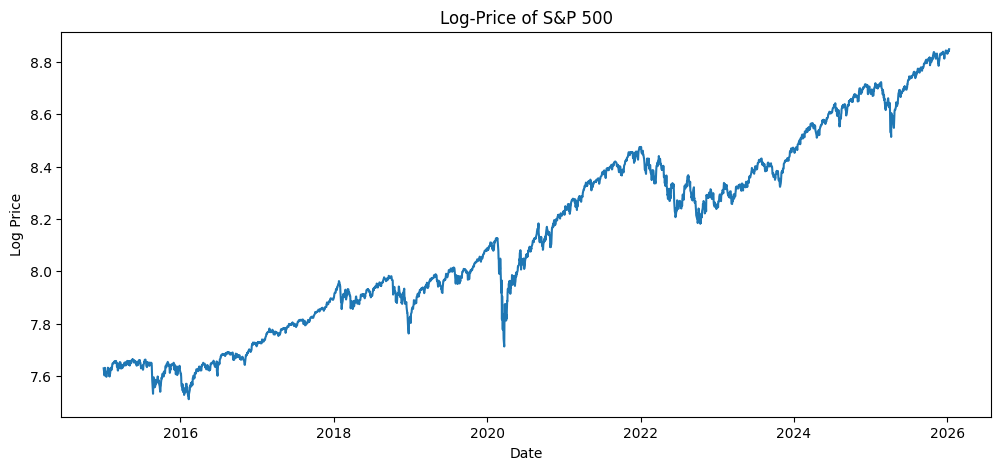

In [74]:
plt.figure(figsize=(12,5))
plt.plot(np.log(data['Close']))
plt.title("Log-Price of S&P 500")
plt.xlabel("Date")
plt.ylabel("Log Price")
plt.show()


### Daily Returns

Returns are analyzed instead of prices because:
- Returns are stationary (prices are not)
- Risk is defined in return space
- Most quantitative strategies operate on returns
- Adjusted prices account for dividends and splits and are required for accurate return calculations.

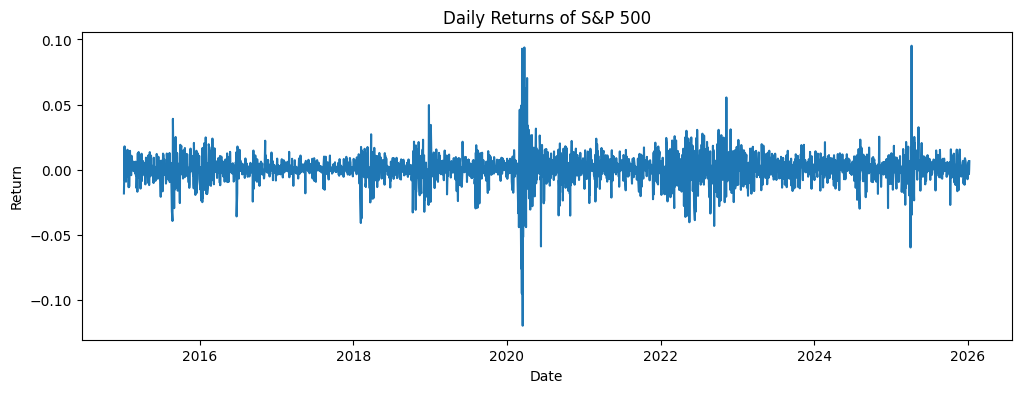

In [75]:
data['Returns'] = data['Close'].pct_change()
data = data.dropna()

plt.figure(figsize=(12,4))
plt.plot(data['Returns'])
plt.title("Daily Returns of S&P 500")
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()


### Return Statistics

We compute key descriptive statistics to understand return distribution.


In [76]:
stats = {
    "Mean Daily Return": data['Returns'].mean(),
    "Volatility (Std)": data['Returns'].std(),
    "Skewness": data['Returns'].skew(),
    "Kurtosis": data['Returns'].kurtosis()
}

pd.Series(stats)


Mean Daily Return     0.000504
Volatility (Std)      0.011272
Skewness             -0.364731
Kurtosis             15.126114
dtype: float64

### Annualized Risk Metrics

Annualized metrics assume 252 trading days.  

Sharpe Ratio is computed assuming a zero risk-free rate for simplicity.


In [77]:
annualized_return = data['Returns'].mean() * 252
annualized_vol = data['Returns'].std() * np.sqrt(252)
risk_free_rate = 0.0
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_vol


pd.Series({
    "Annualized Return": annualized_return,
    "Annualized Volatility": annualized_vol,
    "Sharpe Ratio": sharpe_ratio
})


Annualized Return        0.126963
Annualized Volatility    0.178936
Sharpe Ratio             0.709540
dtype: float64

### Drawdown Analysis

Drawdowns capture downside risk ignored by volatility.


Maximum Drawdown: -33.92%


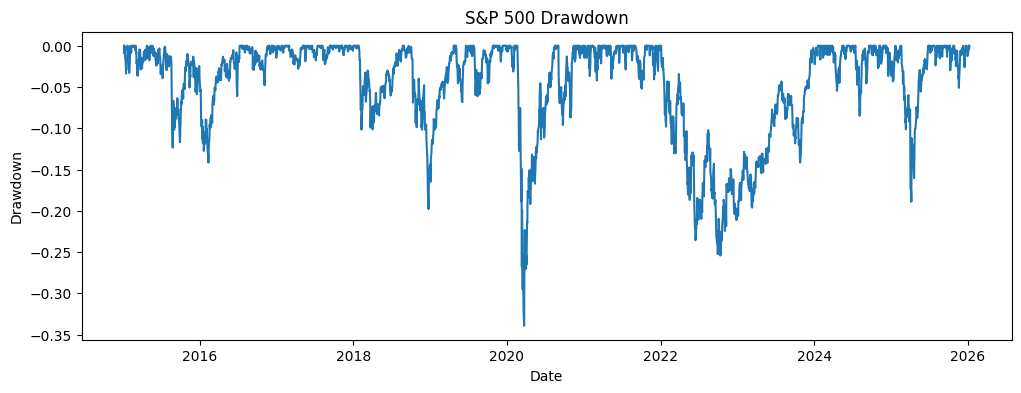

np.float64(-0.3392496000265331)

In [78]:
cum_returns = (1 + data['Returns']).cumprod()
rolling_max = cum_returns.cummax()
drawdown = (cum_returns - rolling_max) / rolling_max
max_dd = drawdown.min()
print(f"Maximum Drawdown: {max_dd:.2%}")


plt.figure(figsize=(12,4))
plt.plot(drawdown)
plt.title("S&P 500 Drawdown")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.show()

drawdown.min()


### Rolling volatility

Rolling volatility is annualized using √252 and expressed in percentage terms.

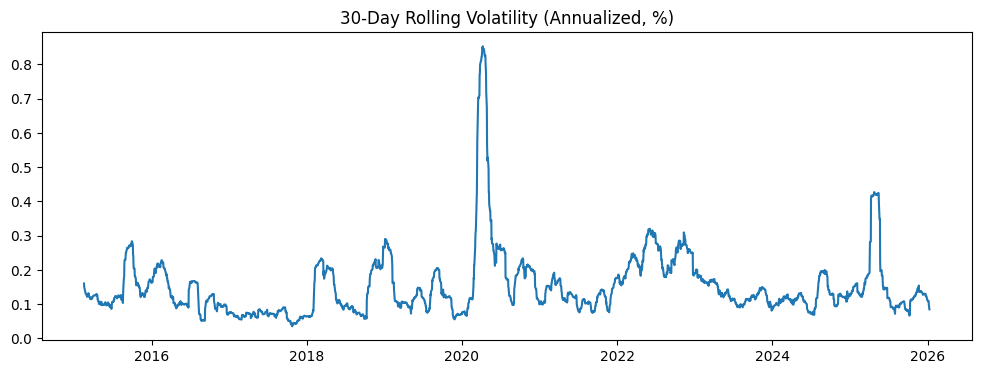

In [79]:
data['RollingVol_30'] = data['Returns'].rolling(30).std() * np.sqrt(252)

plt.figure(figsize=(12,4))
plt.plot(data['RollingVol_30'])
plt.title("30-Day Rolling Volatility (Annualized, %)")
plt.show()


We classify volatility regimes using the median rolling volatility as a simple, distribution-robust threshold.

In [80]:
vol_threshold = data['RollingVol_30'].median()
vol_threshold


np.float64(0.12479549056019992)

In [81]:
data['Vol_Regime'] = np.where(
    data['RollingVol_30'] > vol_threshold,
    'High Volatility',
    'Low Volatility'
)


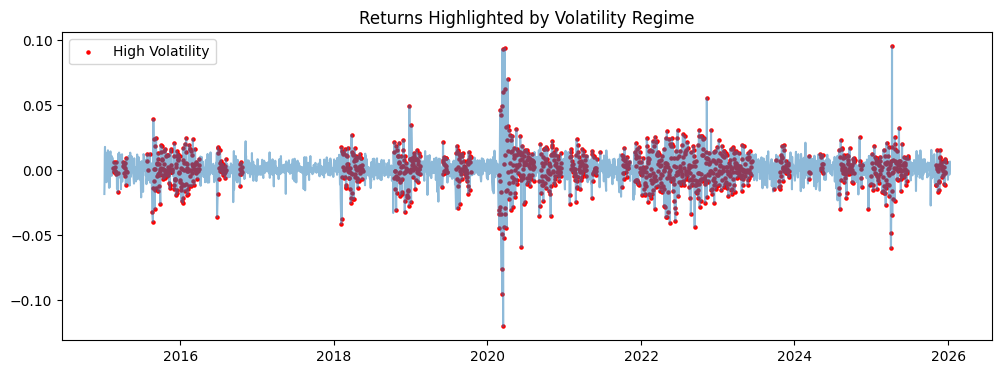

In [82]:
plt.figure(figsize=(12,4))
plt.plot(data['Returns'], alpha=0.5)

high_vol = data['Vol_Regime'] == 'High Volatility'
plt.scatter(
    data.index[high_vol],
    data.loc[high_vol, 'Returns'],
    color='red',
    s=5,
    label='High Volatility'
)

plt.legend()
plt.title("Returns Highlighted by Volatility Regime")
plt.show()


High-volatility periods are associated with larger return dispersion and increased downside risk.

In [83]:
regime_stats = data.groupby('Vol_Regime')['Returns'].agg(
    Mean_Return='mean',
    Volatility='std',
    Skewness='skew',
    Kurtosis=lambda x: x.kurt()
)

regime_stats


,Mean_Return,Volatility,Skewness,Kurtosis
Vol_Regime,,,,
High Volatility,0.000525,0.014698,-0.288926,9.525955
Low Volatility,0.000483,0.006325,-0.583247,2.000549


- Kurtosis is computed explicitly using a lambda function to ensure compatibility across pandas versions and to measure excess kurtosis (excess kurtosis; fat tails relative to normal distribution ) in return distributions.

- Return distributions differ significantly across volatility regimes, particularly in variance and tail behavior.

In [84]:
regime_annual = data.groupby('Vol_Regime')['Returns'].agg(
    Annualized_Return=lambda x: x.mean() * 252,
    Annualized_Volatility=lambda x: x.std() * np.sqrt(252)
)
regime_annual

,Annualized_Return,Annualized_Volatility
Vol_Regime,,
High Volatility,0.132323,0.233328
Low Volatility,0.121713,0.100408


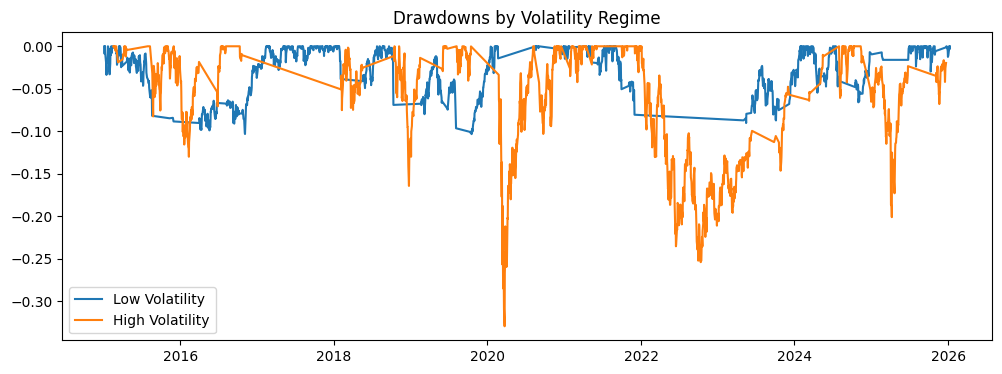

In [85]:
plt.figure(figsize=(12,4))

for regime in ['Low Volatility', 'High Volatility']:
    subset = data[data['Vol_Regime'] == regime]
    cum = (1 + subset['Returns']).cumprod()
    dd = cum / cum.cummax() - 1
    plt.plot(dd, label=regime)

plt.legend()
plt.title("Drawdowns by Volatility Regime")
plt.show()


Drawdowns during high-volatility regimes are deeper and recover more slowly.

### Histogram of returns

The distribution exhibits fat tails and negative skewness, highlighting the presence of extreme downside events not captured by normal assumptions.

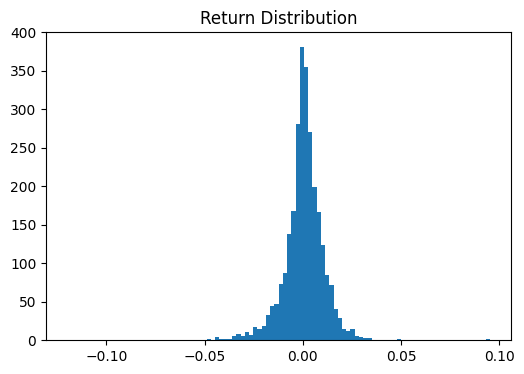

In [86]:
plt.figure(figsize=(6,4))
plt.hist(data['Returns'], bins=100)
plt.title("Return Distribution")
plt.show()


### Interpretation

- Volatility clustering confirms non-constant variance in equity returns
- Drawdowns highlight asymmetric downside risk

- Risk-adjusted performance varies significantly across regimes

- Simple descriptive statistics already reveal meaningful market structure



### Volatility Regime Insights


- High-volatility regimes exhibit higher variance, fatter tails, and deeper drawdowns

- Risk-adjusted performance deteriorates during high-volatility periods

- Low-volatility regimes are associated with more stable compounding

- Volatility regimes cluster over time, indicating regime persistence

- Simple regime classification already provides actionable risk context

## This analysis is descriptive and does not incorporate predictive modeling or trading strategies.